# Cell-type deconvolution using Tangram

In this tutorial, we show how to leverage Squidpy's `squidpy.im.ImageContainer` for cell-type deconvolution tasks.

Mapping single-cell atlases to spatial transcriptomics data is a crucial analysis steps to integrate cell-type annotation across technologies. Information on the number of nuclei under each spot can help cell-type deconvolution methods.
Tangram <strong data-cite="tangram">Biancalani et al. (2020)</strong>, ([code](https://github.com/broadinstitute/Tangram)) is a cell-type deconvolution method that enables mapping of cell-types to single nuclei under each spot. We will show how to leverage the image container segmentation capabilities, together with Tangram, to map cell types of the mouse cortex from sc-RNA-seq data to Visium data.

To run the notebook locally, create a conda environment as *conda env create -f tangram_environment.yml* using this [tangram_environment.yml](https://github.com/theislab/squidpy_notebooks/blob/master/envs/tangram_environment.yml). 

First, let's import some libraries.

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns

# import tangram for spatial deconvolution
import sys
sys.path.insert(1, 'TASKS/tg_dev/Tangram')
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.0


* We will load the public data available in Squidpy.

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

* Here, we subset the crop of the mouse brain to only contain clusters of the brain cortex. The pre-processed single cell dataset was taken from <strong data-cite="tasic2018shared">Tasic et al. (2018)</strong> and pre-processed with standard scanpy functions. To start off, let's visualize both spatial and single-cell datasets.

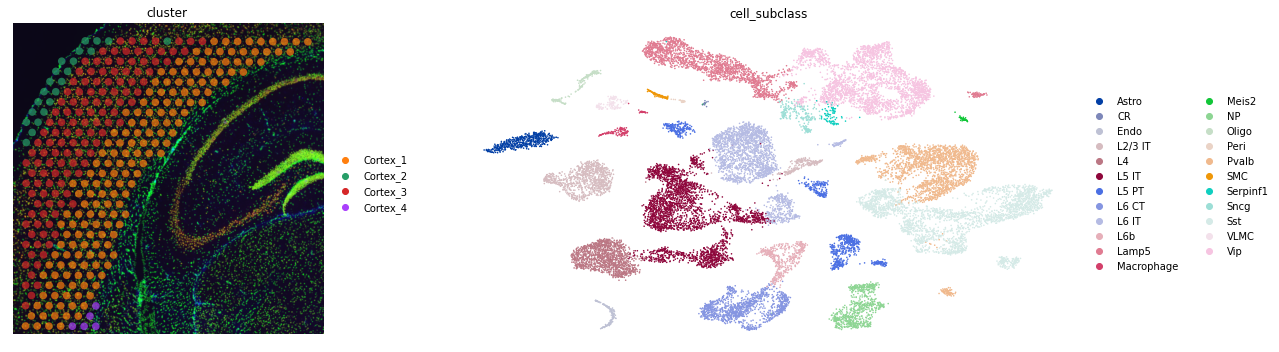

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

## Nuclei segmentation and segmentation features
* As mentioned before, we are interested in segmenting single nuclei under each spot in the Visium dataset. Squidpy makes it possible with two lines of Python code:

    * `squidpy.im.process` applies smoothing as a pre-processing step.
    * `squidpy.im.segment` computes segmentation masks with watershed algorithm.

In [4]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)

* Let's visualize the results for an inset:

Text(0.5, 1.0, 'Nucleous segmentation')

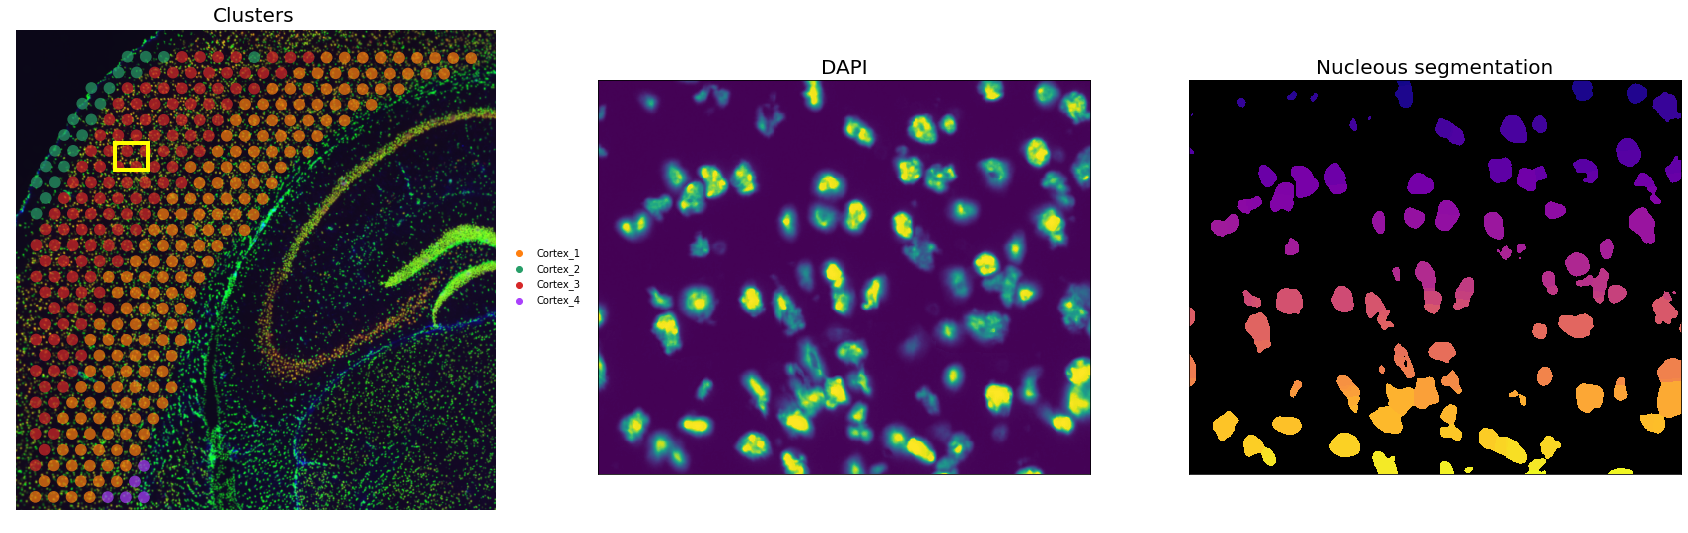

In [5]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0, 0]
    / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values.squeeze(-1)
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20})

* We can appreciate that despite some false positive, the nuclei segmentation worked well.

* We then need to extract some image features useful for the deconvolution task downstream. Specifically, we will need:
    * the number of unique segmentation objects (i.e. nuclei) under each spot.
    * the coordinates of the centroids of the segmentation object.

* It will become clear later how we will be using them.

In [6]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

We can visualize the total number of objects under each spot with scanpy.

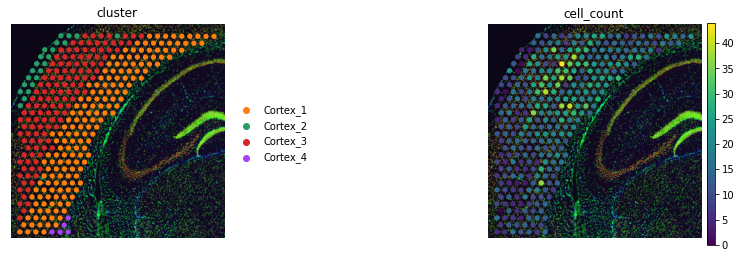

In [7]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

At this stage, we have all we need for the deconvolution task.

## Deconvolution and mapping

### Prepare to map

- Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data_.
- In doing this, Tangram only looks at a subset genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- Typically, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types. Sometimes, we also use the entire transcriptome, or perform different mappings using different set of training genes to see how much the result change.
- For this case, we choose 1401 marker genes

In [8]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)

In [9]:
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1401

- We now need to prepare the datasets for mapping by creating `training_genes` field in `uns` dictionary of the two AnnData structures. 
- This `training_genes` field contains genes subset on the list of training genes. This field will be used later inside the mapping function to create training datasets.
- Also, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.
- And if data entries of a gene are all zero, this gene will be removed
- This task is performed by the helper `pp_adatas`.

In [10]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


- You'll now notice that the two datasets now contain 1280 genes, but 1401 markers were provided.
- This is because the marker genes need to be shared by both dataset. If a gene is missing, `pp_adatas` will just take it out.
- Finally, the `assert` line below is a good way to ensure that the genes in the `training_genes` field in `uns` are actually ordered in both `AnnData`s.

In [11]:
assert adata_sc.uns['training_genes' ] == adata_st.uns['training_genes']

### Map

- We can now train the model (_ie_ map the single cell data onto space).
- Mapping should be interrupted after the score plateaus,which can be controlled by passing the `num_epochs` parameter. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data: higher score means better mapping.
- Note that we obtained excellent mapping even if Tangram converges to a low scores (the typical case is when the spatial data are very sparse): we use the score merely to assess convergence.
- If you are running Tangram with a GPU, set `device=cuda:0` otherwise use the set `device=cpu`. On a MacBook Pro 2018, it takes ~1h to run. On a P100 GPU it should be done in a few minutes.
- For basic mapping, we do not use regularizers. More sophisticated loss functions can be used using the Tangram library (refer to manuscript or dive into the code). For example, you can pass your `density_prior` with the hyperparameter `lambda_d` (default value is 1 when density_prior is given) to regularize the spatial density of cells. Currently `uniform`, `rna_count_based` and customized input array are supported for `density_prior` argument. In below example, `target_count` is also used to regularize the number of cells in the mapping.
- Instead of mapping single cells, we can "average" the cells within a cluster and map the averaged cells instead, which drammatically improves performances. This suggestion was proposed by Sten Linnarsson. To activate this mode, select `mode='clusters'` and pass the annotation field to `cluster_label`.

In [12]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cuda:0",
#     device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and customized density_prior in constrained mode...


Score: 0.613, KL reg: 0.125, Count reg: 5733.874, Lambda f reg: 4492.078
Score: 0.699, KL reg: 0.012, Count reg: 1.043, Lambda f reg: 741.459
Score: 0.702, KL reg: 0.012, Count reg: 1.219, Lambda f reg: 245.425
Score: 0.702, KL reg: 0.012, Count reg: 0.112, Lambda f reg: 173.633
Score: 0.702, KL reg: 0.012, Count reg: 0.125, Lambda f reg: 136.485
Score: 0.702, KL reg: 0.012, Count reg: 0.958, Lambda f reg: 118.897
Score: 0.702, KL reg: 0.012, Count reg: 1.384, Lambda f reg: 108.077
Score: 0.702, KL reg: 0.012, Count reg: 0.021, Lambda f reg: 100.120
Score: 0.702, KL reg: 0.012, Count reg: 0.426, Lambda f reg: 89.025
Score: 0.702, KL reg: 0.012, Count reg: 0.150, Lambda f reg: 81.794


INFO:root:Saving results..


- The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:
    - The cell-by-spot matrix `X` contains the probability of cell `i` to be in spot `j`.
    - The `obs` dataframe contains the metadata of the single cells.
    - The `var` dataframe contains the metadata of the spatial data.
    - The `uns` dictionary contains a dataframe with various information about the training genes (saved ad `train_genes_df`).

### Evalution and analysis

- The most common application for mapping single cell data onto space is to transfer the cell type annotations onto space.
- This is dona via `plot_cell_annotation`, which visualizes spatial probability maps of the `annotation` in the `obs` dataframe (here, the `subclass_label` field). You can set the `perc` argument to set the range to the colormap, which would help remove outliers.

In [13]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


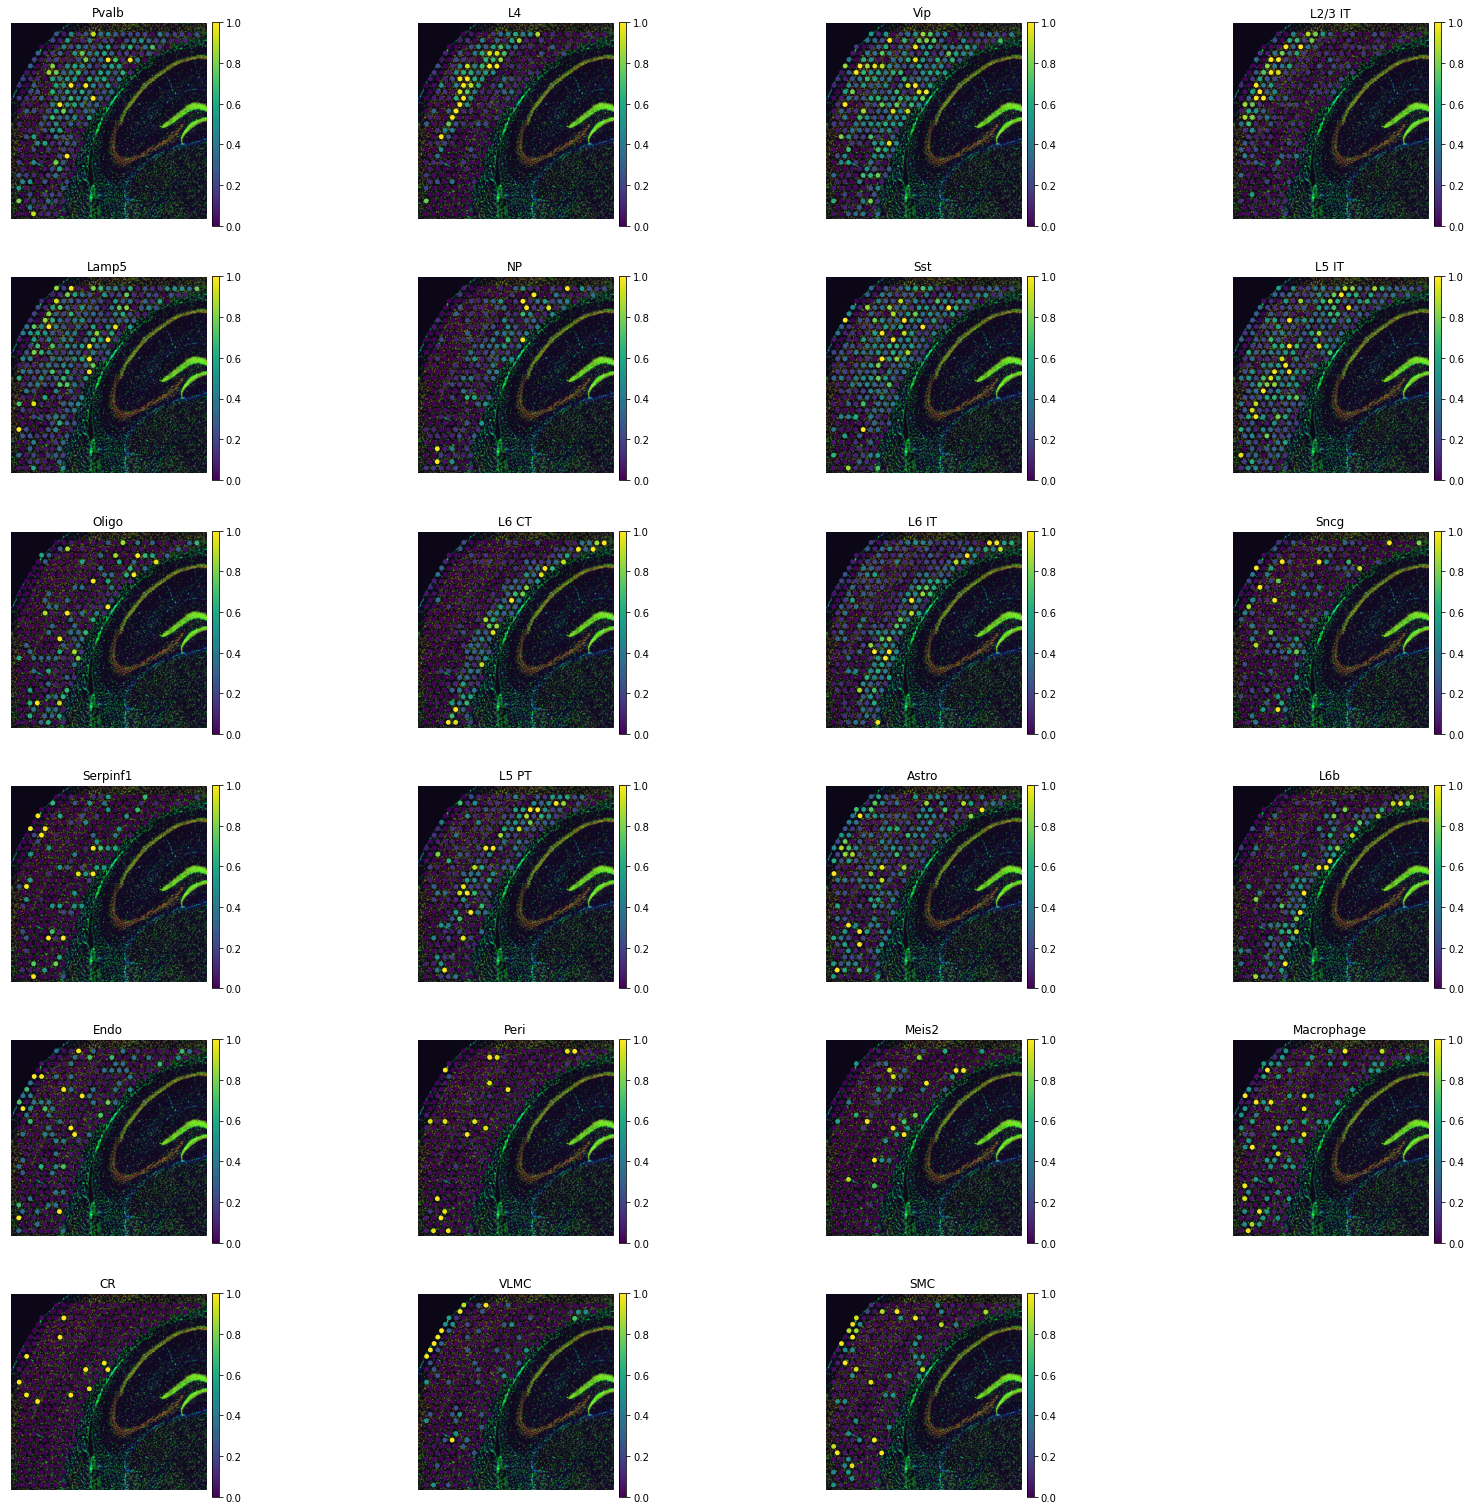

In [14]:
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
tg.plot_cell_annotation(adata_st, annotation_list, perc=0.02)

- Let's try to get a deeper sense of how good this mapping is. A good helper is `plot_training_scores` which gives us four panels:
    - The first panels is a histogram of the simlarity score for each training gene. Most genes are mapped with high similarity (> .6) although few of them have score (<= ~.5). We would like to understand why for these genes the score is lower.
    - In the second panel, each dot is a training gene and we can observe the training score (y-axis) and the sparsity in the scRNA-seq data (x-axis) of each gene. 
    - The third panel is similar to the second one, but contains the gene sparsity of the spatial data. Spatial data are usually more sparse than single cell data, a discrepancy which is often responsible for low quality mapping.
    - In the last panel, we show the training scores as a function of the difference in sparsity between the dataset. For genes with comparable sparsity, the mapped gene expression is very similar to that in the spatial data. However, if a gene is quite sparse in one dataset (typically, the spatial data) but not in other, the mapping score is lower. This occurs as Tangram cannot properly matched the gene pattern because of inconsistent amount of dropouts between the datasets.

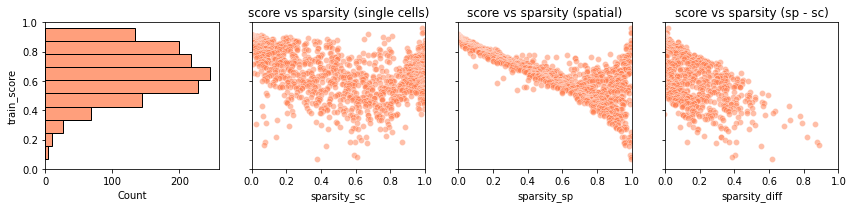

In [15]:
tg.plot_training_scores(ad_map, bins=10, alpha=.5)

- Although the above plots give us a summary of scores at single-gene level, we would need to know _which_ are the genes are mapped with low scores.
- These information can be access from the dataframe `.uns['train_genes_df']` from the mapping results; this is the dataframe used to build the four plots above.

In [16]:
ad_map.uns['train_genes_df']

train_score  sparsity_sc  sparsity_sp  sparsity_diff
cxcr4        0.961310     0.981610     0.996914       0.015303
gm27199      0.934413     0.989722     0.996914       0.007191
nhlh2        0.928436     0.984514     0.996914       0.012400
apoe         0.919904     0.668203     0.000000      -0.668203
ppia         0.913444     0.000092     0.000000      -0.000092
...               ...          ...          ...            ...
trim17       0.159804     0.069641     0.959877       0.890236
cdyl2        0.157443     0.425911     0.981481       0.555570
dlx1as       0.096122     0.587777     0.990741       0.402964
cntnap5c     0.082006     0.608241     0.993827       0.385586
kcnh6        0.068127     0.379131     0.996914       0.617783

[1280 rows x 4 columns]

- We want to inspect gene expression of training genes mapped with low scores, to understand the quality of mapping. 
- First, we need to generate "new spatial data" using the mapped single cell: this is done via `project_genes`.
- The function accepts as input a mapping (`adata_map`) and corresponding single cell data (`adata_sc`).
- The result is a voxel-by-gene `AnnData`, formally similar to `adata_st`, but containing gene expression from the mapped single cell data rather than visium.

In [17]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'cell_count', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'rank_genes_groups', 'training_genes', 'overlap_genes'

* We now choose a few training genes mapped with low score.

In [18]:
genes = ['dlx1as', 'cntnap5c',  'kcnh6']
ad_map.uns['train_genes_df'].loc[genes]

train_score  sparsity_sc  sparsity_sp  sparsity_diff
dlx1as       0.096122     0.587777     0.990741       0.402964
cntnap5c     0.082006     0.608241     0.993827       0.385586
kcnh6        0.068127     0.379131     0.996914       0.617783

- To visualize gene patterns, we use the helper `plot_genes`. This function accepts two voxel-by-gene `AnnData`: the actual spatial data  (`adata_measured`), and a Tangram spatial prediction (`adata_predicted`). The function returns gene expression maps from the two spatial `AnnData` on the genes `genes`.
- As expected, the predited gene expression is less sparse albeit the main patterns are captured. For these genes, we trust more the mapped gene patterns, as Tangram "corrects" gene expression by aligning in space less sparse data.

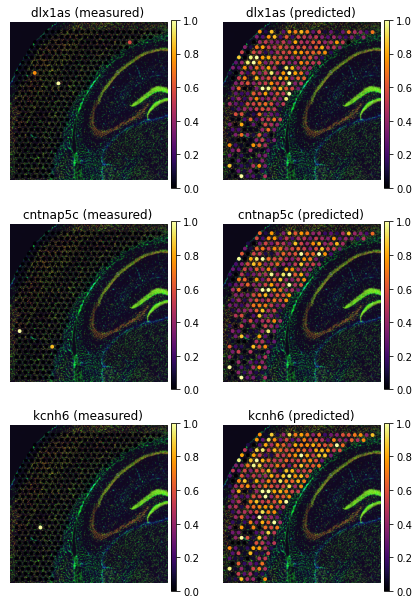

In [19]:
tg.plot_genes(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

- An even stronger example is found in genes that are not detected in the spatial data, but are detected in the single cell data. They are removed before training with `pp_adatas` function. But tangram could still generate insight on how the spatial patterns look like.

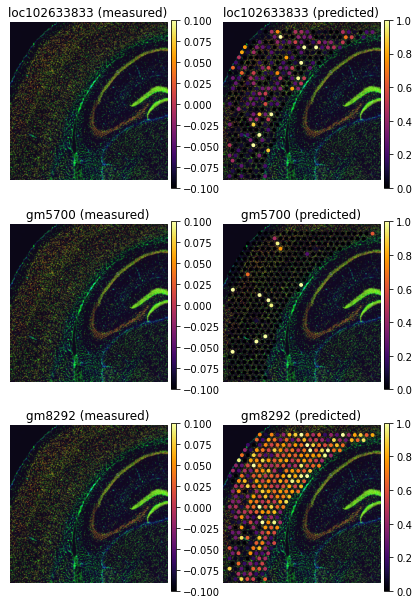

In [20]:
genes=['loc102633833', 'gm5700', 'gm8292']
tg.plot_genes(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

* So far, we only inspected genes used to align the data (training genes), but the mapped single cell data, `ad_ge` contains the whole transcriptome. That includes more than 35k test genes.

In [21]:
(ad_ge.var.is_training == False).sum()

35546

* We can use `plot_genes` to inspect gene expression of non-training genes. This is an essential step as prediction of gene expression is the way we validate mapping.
* Before doing that, it is convenient to compute the similarity scores of all genes, which can be done by `compare_spatial_geneexp`. This function accepts two spatial AnnDatas (ie voxel-by-gene), and returns a dataframe with simlarity scores for all genes. Training genes are flagged by the Boolean field `is_training`.
* If we also pass single cell AnnData to `compare_spatial_geneexp` function like below, a dataframe with additional sparsity columns - sparsity_sc (single cell data sparsity) and sparsity_diff (spatial data sparsity - single cell data sparsity) will return. This is required if we want to call `plot_test_scores` function later with the returned datafrme from compare_spatial_geneexp function.

In [22]:
df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
df_all_genes

score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
cxcr4    0.961310         True     0.996914     0.981610       0.015303
gm27199  0.934413         True     0.996914     0.989722       0.007191
nhlh2    0.928436         True     0.996914     0.984514       0.012400
apoe     0.919904         True     0.000000     0.668203      -0.668203
hspa8    0.914752        False     0.000000     0.000784      -0.000784
...           ...          ...          ...          ...            ...
prr32    0.000021        False     0.993827     0.999263      -0.005435
foxd2    0.000020        False     0.996914     0.998064      -0.001151
cyp3a13  0.000017        False     0.996914     0.998479      -0.001565
klk1     0.000016        False     0.996914     0.999539      -0.002626
tdgf1    0.000011        False     0.996914     0.999263      -0.002349

[14785 rows x 5 columns]

* The plot below give us a summary of scores at single-gene level for test genes

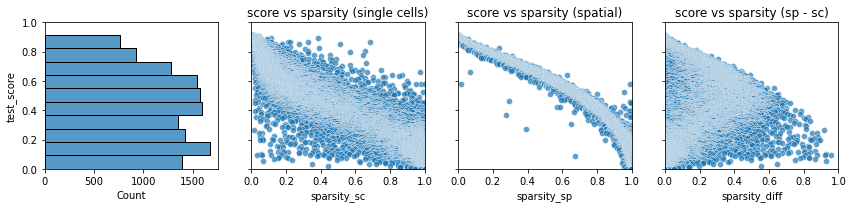

In [23]:
tg.plot_test_scores(df_all_genes)

* Let's plot the scores of the test genes and see how they compare to the training genes. Following the strategy in the previous plots, we visualize the scores as a function of the sparsity of the spatial data.
* (We have not wrapped this call into a function yet).

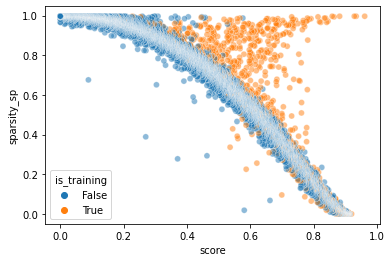

In [24]:
sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5);

* Again, sparser genes in the spatial data are predicted with low scores, which is due to the presence of dropouts in the spatial data.

### Deconvolution

* And here comes the key part, where we will use the results of the previous deconvolution steps. Previously, we computed the absolute numbers of unique segmentation objects under each spot, together with their centroids. Let's extract them in the right format useful for Tangram.

* In the resulting dataframe, each row represents a single segmentation object (therefore a single nuclei). We also have the image coordinates as well as the unique centroid ID, which is a string that contains both the spot ID and a numerical index.

* Tangram provide a convenient function to export the mapping between spot ID and segmentation ID to adata.uns.

In [25]:
tg.create_segment_cell_df(adata_st)

In [26]:
adata_st.uns["tangram_cell_segmentation"].head()

spot_idx            y           x             centroids
0  AAATGGCATGTCTTGT-1  5304.000000  731.000000  AAATGGCATGTCTTGT-1_0
1  AAATGGCATGTCTTGT-1  5320.947519  721.331554  AAATGGCATGTCTTGT-1_1
2  AAATGGCATGTCTTGT-1  5332.942342  717.447904  AAATGGCATGTCTTGT-1_2
3  AAATGGCATGTCTTGT-1  5348.865384  558.924248  AAATGGCATGTCTTGT-1_3
4  AAATGGCATGTCTTGT-1  5342.124989  567.208502  AAATGGCATGTCTTGT-1_4

* We can then use `tangram.count_cell_annotation()` to map cell types as result of the deconvolution step to putative segmentation ID.

In [27]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)

In [28]:
adata_st.obsm["tangram_ct_count"].head()

x     y  cell_n  \
AAATGGCATGTCTTGT-1   641  5393      13   
AACAACTGGTAGTTGC-1  4208  1672      16   
AACAGGAAATCGAATA-1  1117  5117      28   
AACCCAGAGACGGAGA-1  1101  1274       5   
AACCGTTGTGTTTGCT-1   399  4708       7   

                                                            centroids  Pvalb  \
AAATGGCATGTCTTGT-1  [AAATGGCATGTCTTGT-1_0, AAATGGCATGTCTTGT-1_1, A...      1   
AACAACTGGTAGTTGC-1  [AACAACTGGTAGTTGC-1_0, AACAACTGGTAGTTGC-1_1, A...      2   
AACAGGAAATCGAATA-1  [AACAGGAAATCGAATA-1_0, AACAGGAAATCGAATA-1_1, A...      3   
AACCCAGAGACGGAGA-1  [AACCCAGAGACGGAGA-1_0, AACCCAGAGACGGAGA-1_1, A...      1   
AACCGTTGTGTTTGCT-1  [AACCGTTGTGTTTGCT-1_0, AACCGTTGTGTTTGCT-1_1, A...      2   

                    L4  Vip  L2/3 IT  Lamp5  NP  ...  L5 PT  Astro  L6b  Endo  \
AAATGGCATGTCTTGT-1   0    1        0      1   0  ...      2      0    0     0   
AACAACTGGTAGTTGC-1   0    3        0      1   1  ...      0      0    1     0   
AACAGGAAATCGAATA-1   1    2        0      2   1  ...      0      0    0     1   
AACCCAGAGACGGAGA-1   0    1        1      0   0  ...      0      1    0     0   
AACCGTTGTGTTTGCT-1   0    0        0      0   0  ...      0      1    0     1   

                    Peri  Meis2  Macrophage  CR  VLMC  SMC  
AAATGGCATGTCTTGT-1     0      0           0   0     0    0  
AACAACTGGTAGTTGC-1     0      0           1   0     0    0  
AACAGGAAATCGAATA-1     0      1           0   0     0    0  
AACCCAGAGACGGAGA-1     0      0           2   0     0    0  
AACCGTTGTGTTTGCT-1     0      0           0   0     0    0  

[5 rows x 27 columns]

* And then finally export the results in a new `AnnData` object.

In [29]:
adata_segment = tg.deconvolve_cell_annotations(adata_st)

In [30]:
adata_segment.obs.head()

y           x             centroids cluster
0  5304.000000  731.000000  AAATGGCATGTCTTGT-1_0   Pvalb
1  5320.947519  721.331554  AAATGGCATGTCTTGT-1_1     Vip
2  5332.942342  717.447904  AAATGGCATGTCTTGT-1_2   Lamp5
3  5348.865384  558.924248  AAATGGCATGTCTTGT-1_3   L5 IT
4  5342.124989  567.208502  AAATGGCATGTCTTGT-1_4   L5 IT

* Note that the AnnData object does not contain counts, but only cell type annotations, as results of the Tangram mapping. 
Nevertheless, it's convenient to create such AnnData object for visualization purposes.

* Below you can appreciate how each dot is now not a Visium spot anymore, but a single unique segmentation object, with the mapped cell type.

[<AxesSubplot:title={'center':'cluster'}, xlabel='spatial1', ylabel='spatial2'>]

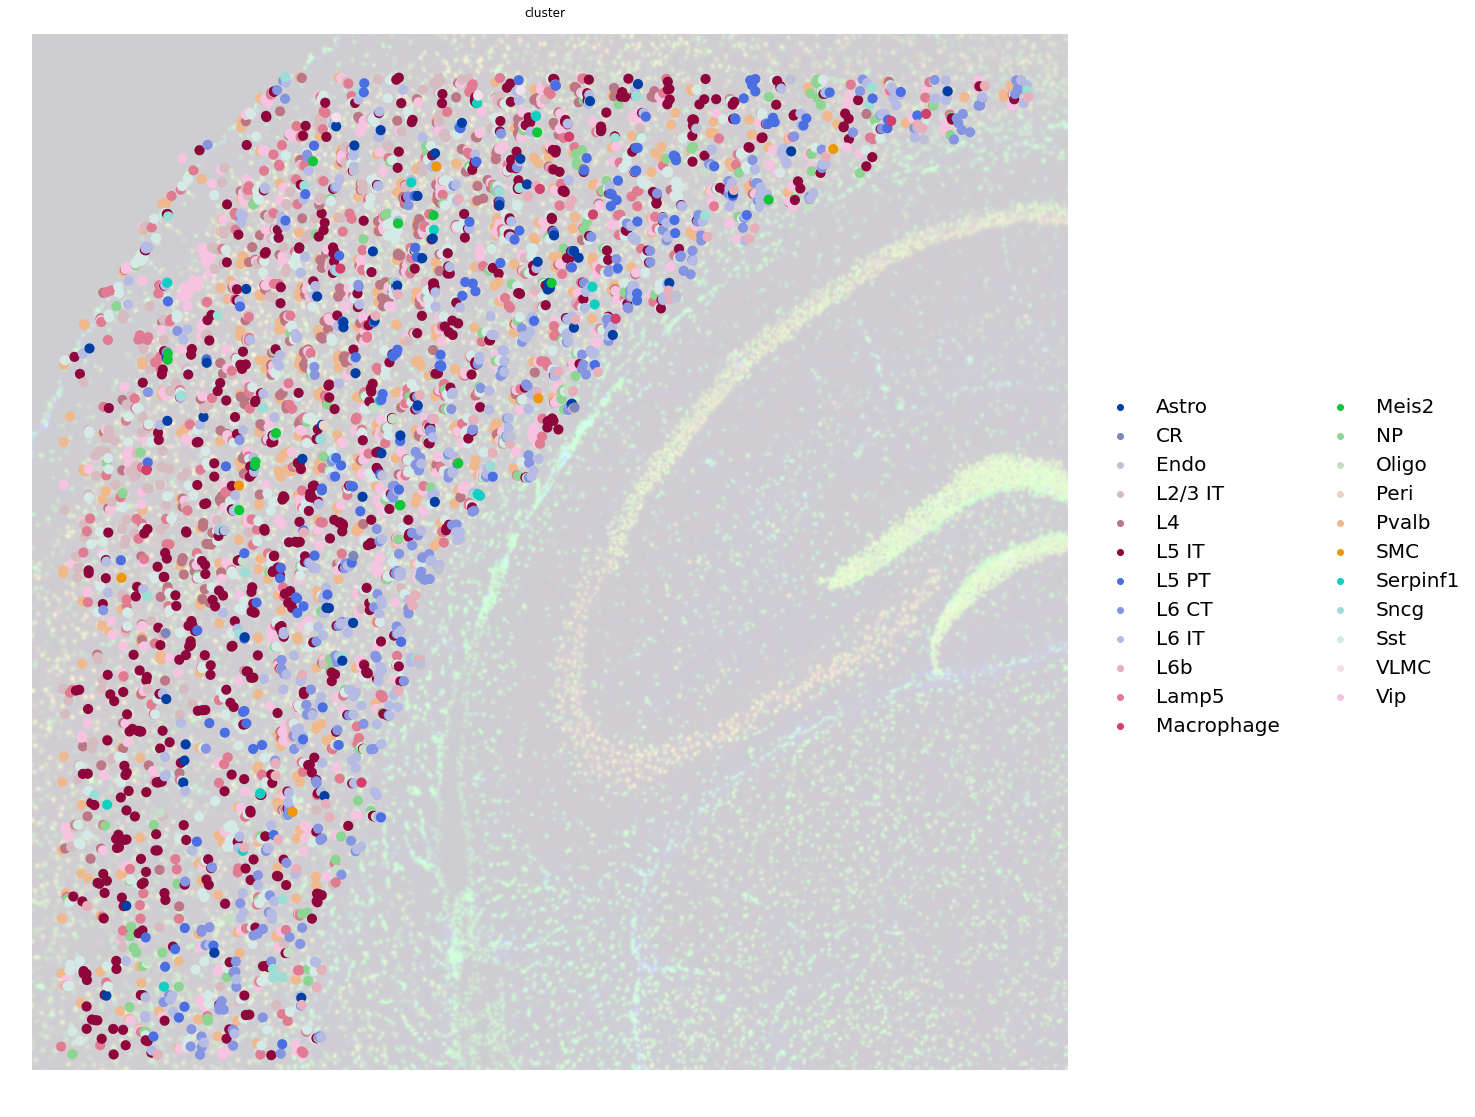

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    size=0.4,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
    ax=ax,
)

In [33]:
"do we show below part or not, seems not relevant to squidpy deconvolve topic"

'do we show below part or not, seems not relevant to squidpy deconvolve topic'

***
### Leave-One-Out Cross Validation (LOOCV)

- If number of genes is small, Leave-One-Out cross validation (LOOCV) is supported in Tangram to evaluate mapping performance. 
- LOOCV supported by Tangram:
    - Assume the number of genes we have in the dataset is N. 
    - LOOCV would iterate over and map on the genes dataset N times.
    - Each time it hold out one gene as test gene (1 test gene) and trains on the rest of all genes (N-1 training genes).
    - After all trainings are done, average test/train score will be computed to evaluate the mapping performance.

 - Restart the kernel and load single cell, spatial and gene markers data

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg
import squidpy as sq

In [3]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()

adata_sc = sq.datasets.sc_mouse_cortex()

sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:5, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

96

- Run `pp_adatas` to prepare data for mapping

In [4]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:93 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


- Assume all genes we have is the 96 training genes calculated above. Here we demo the LOOCV mapping at cluster level.

In [5]:
cv_dict, ad_ge_cv, df = tg.cross_val(adata_sc, 
                                     adata_st, 
                                     device='cuda:0', 
                                     mode='clusters',
                                     cv_mode='loo',
                                     num_epochs=1000,
                                     cluster_label='cell_subclass',
                                     return_gene_pred=True,
                                     verbose=False,
                                     )

100%|██████████| 93/93 [17:26<00:00, 11.26s/it]

cv avg test score 0.687
cv avg train score 0.777


* cross_val function will return cv_dict and ad_ge_cv and df_test_genes in LOOCV mode. cv_dict contains the average score for cross validation, ad_ge_cv stores the predicted expression value for each gene, and df_test_genes contains scores and sparsity for each test genes.m

In [10]:
cv_dict

{'avg_test_score': 0.6870605, 'avg_train_score': 0.777285227852483}

* We can use plot_test_scores to display an overview of the cross validation test scores of each gene vs. sparsity.

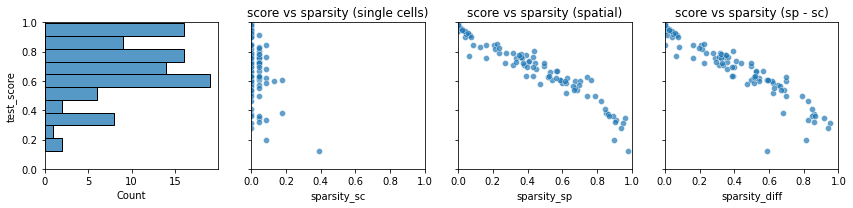

In [7]:
tg.plot_test_scores(df, bins=10, alpha=.7)

* Now, let's compare a few genes between their ground truth and cross-validation predicted spatial pattern by calling the function plot_genes

In [8]:
ad_ge_cv.var.sort_values(by='test_score', ascending=False)
ranked_genes = list(ad_ge_cv.var.sort_values(by='test_score', ascending=False).index.values)
top_genes = ranked_genes[:3]
bottom_genes = ranked_genes[-3:]

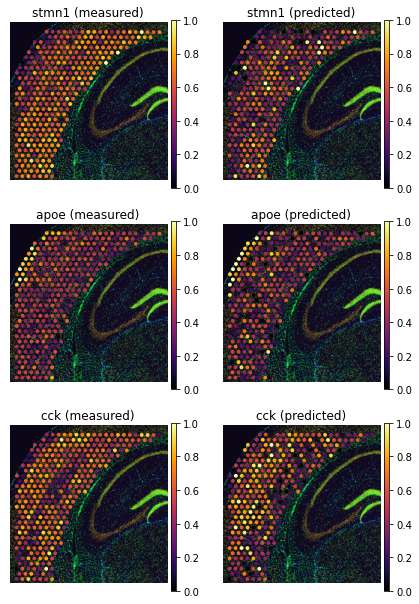

In [13]:
tg.plot_genes(genes=top_genes, adata_measured=adata_st, adata_predicted=ad_ge_cv, perc=0.02)

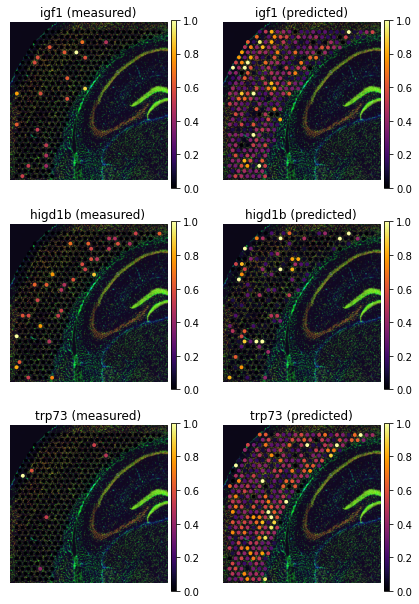

In [15]:
tg.plot_genes(genes=bottom_genes, adata_measured=adata_st, adata_predicted=ad_ge_cv, perc=0.02)